# Programa para la adquisición de datos en 4 canales simultáneamente

Información sobre inicializar el sistema y toma de datos en https://digilent.com/reference/test-and-measurement/guides/waveforms-sdk-getting-started.

* Sección 1: Importing the Constants and Loading the Dynamic Library.
* Sección 2: Connecting the Test & Measurement Device.
* Seccion 3.5.1: Initialize the Logic Analyzer.
* Sección 3.5.2: Record Logic Signals.
* Sección 3.5.3: Reset the Logic Analyzer.

Pequeñas variaciones han sido incluidas para poder tomar adqusición simultánea en varios canales (en concreto, en los canales 1, 2, 14 y 15).

### Import libraries

In [129]:
from ctypes import (cdll, c_int, c_double, c_ubyte, byref, create_string_buffer,
                    c_uint16)                # import the C compatible data types
from sys import platform, path    # this is needed to check the OS type and get the PATH
from os import sep   # OS specific file path separators
import ctypes
import numpy as np
import time
 
# load the dynamic library, get constants path (the path is OS specific)
if platform.startswith("win"):
    # on Windows
    dwf = ctypes.cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif platform.startswith("darwin"):
    # on macOS
    lib_path = sep + "Library" + sep + "Frameworks" + sep + "dwf.framework" + sep + "dwf"
    dwf = ctypes.cdll.LoadLibrary(lib_path)
    constants_path = sep + "Applications" + sep + "WaveForms.app" + sep + "Contents" + sep + "Resources" + sep + "SDK" + sep + "samples" + sep + "py"
else:
    # on Linux
    dwf = ctypes.cdll.LoadLibrary("libdwf.so")
    constants_path = sep + "usr" + sep + "share" + sep + "digilent" + sep + "waveforms" + sep + "samples" + sep + "py"
 
# import constants
path.append(constants_path)
import dwfconstants as constants

### Open and init device

In [130]:
class device_data:
    """
        stores the device handle and the device name
    """
    handle = ctypes.c_int(0)
    name = ""
 
def initialize_device():
    """
        initialize_device the first available device
    """
    # handle for the digilent device
    hdwf = c_int()

    # print DWF version
    version = create_string_buffer(14)
    dwf.FDwfGetVersion(version)
    print("DWF Version: "+version.value.decode("utf-8"))

    # initialize_device device
    print("Opening first device")
    dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))

    # check if device is initialize_device
    if hdwf.value == 0:
        print("Failed to initialize_device device")
        szerr = create_string_buffer(512)
        dwf.FDwfGetLastErrorMsg(szerr)
        print(szerr.value.decode("utf-8"))
        assert False
        
    device_data.handle = hdwf

In [145]:
samp_freq = 1e9

class data:
    """ stores the sampling frequency and the buffer size """
    sampling_frequency = samp_freq # Si se cambia, cambiar también en la función open_logic
    buffer_size = 8192*2
 
def open_logic(device_data, sampling_frequency=samp_freq):
    """
        initialize the logic analyzer
        parameters: - device data
                    - sampling frequency in Hz, default is 100MHz
                    - buffer size, default is 4096
    """
    # get internal clock frequency
    internal_frequency = ctypes.c_double()
    dwf.FDwfDigitalInInternalClockInfo(device_data.handle, ctypes.byref(internal_frequency))
 
    # set clock frequency divider (needed for lower frequency input signals)
    dwf.FDwfDigitalInDividerSet(device_data.handle, ctypes.c_int(int(internal_frequency.value / sampling_frequency)))
 
    # set 16-bit sample format
    dwf.FDwfDigitalInSampleFormatSet(device_data.handle, ctypes.c_int(16))
    
    # configure channels to read
    dwf.FDwfDigitalInConfigure(device_data.handle, c_int(0), c_int(1), c_int(14), c_int(15))
 
    buffer_size = c_int()
    dwf.FDwfDigitalInBufferSizeInfo(device_data.handle, ctypes.byref(buffer_size))
    
    # set buffer size
    dwf.FDwfDigitalInBufferSizeSet(device_data.handle, buffer_size)
    data.sampling_frequency = sampling_frequency
    data.buffer_size = buffer_size.value // 2
    return

### Obtención de datos

In [146]:
import numpy as np

buffer = 0

def record(device_data):
    """
        initialize the logic analyzer
        parameters: - device data
                    - channel - the selected DIO line number
        returns:    - buffer - a list with the recorded logic values
                    - time - a list with the time moments for each value in seconds (with the same index as "buffer")
    """
    # set up the instrument
    #dwf.FDwfDigitalInConfigure(device_data.handle, ctypes.c_bool(False), ctypes.c_bool(True))
 
    # read data to an internal buffer
    while True:
        status = ctypes.c_byte()    # variable to store buffer status
        dwf.FDwfDigitalInStatus(device_data.handle, ctypes.c_bool(True), ctypes.byref(status))
 
        if status.value == constants.stsDone.value:
            # exit loop when finished
            break
 
    buffer_len = data.buffer_size * 2
    # get samples
    buffer = (ctypes.c_uint16 * buffer_len)()
    dwf.FDwfDigitalInStatusData(device_data.handle, buffer, ctypes.c_int(buffer_len))
    
    buffer = np.array([int(element) for element in buffer])
    
    return buffer
    
 
    """
    # convert buffer to list of lists of integers
    buffer = [int(element) for element in buffer]
    result = [[] for _ in range(16)]
    for point in buffer:
        for index in range(16):
            result[index].append(point & (1 << index))
            
    print(buffer)
 
    # calculate acquisition time
    time = range(0, data.buffer_size)
    time = [moment / data.sampling_frequency for moment in time]
 
    # get channel specific data
    buffer = [result[channel_1], result[channel_2], result[channel_3], result[channel_4]]
    """

## Tomamos tan solo un buffer de datos de longitud max_len

In [147]:
# Inicializamos el osciloscopio
initialize_device()
open_logic(device_data)

datam = record(device_data)

# Apagamos el osciloscopio
dwf.FDwfDeviceClose(device_data.handle) 

DWF Version: 3.22.1
Opening first device


1

## Tomamos varios buffers en un bucle

In [148]:
# Inicializamos el osciloscopioÇ
initialize_device()
open_logic(device_data)

start = time.time()
stop_time = 5

contador = 0 # La variable contador dará el número de veces que hemos tomado datos
datam = np.zeros(0) # Inicializamos la variable en la que guardaremos todos los datso durante el bucle

while (time.time() - start) < stop_time:
    
    datam = np.append(datam, record(device_data))
    contador += 1 # Sumamos un 1 cada vez que tomamos datos

#Convertimos el array 'datam' a datos del tipi int
datam = datam.astype(int)

# Apagamos el osciloscopio
dwf.FDwfDeviceClose(device_data.handle) 
print("Contador: ", contador)

DWF Version: 3.22.1
Opening first device
Contador:  25


In [149]:
print(len(datam))
print(type(datam))
print(datam[30500])

25000000
<class 'numpy.ndarray'>
2


In [150]:
dwf.FDwfDeviceClose(device_data.handle) # Apagamos el osciloscopio

0

In [151]:
len(datam[datam != 0])

11347324

In [152]:
channel_15 = (datam >> 15) & 1
channel_14 = (datam >> 14) & 1
channel_13 = (datam >> 13) & 1
channel_12 = (datam >> 12) & 1
channel_11 = (datam >> 11) & 1
channel_10 = (datam >> 10) & 1
channel_9 = (datam >> 9) & 1
channel_8 = (datam >> 8) & 1
channel_7 = (datam >> 7) & 1
channel_6 = (datam >> 6) & 1
channel_5 = (datam >> 5) & 1
channel_4 = (datam >> 4) & 1
channel_3 = (datam >> 3) & 1
channel_2 = (datam >> 2) & 1
channel_1 = (datam >> 1) & 1
channel_0 = (datam >> 0) & 1

In [153]:
# Asegurándonos de que todos los arrays tengan la misma longitud
length = len(channel_0)
for i in range(1, 16):
    assert len(eval(f'channel_{i}')) == length, f"El array channel_{i} no tiene la misma longitud que channel_0"

# Creando una matriz con todas las columnas
#data = np.column_stack((channel_0, channel_1, channel_2, channel_3, channel_4, channel_5, channel_6, channel_7, channel_8, channel_9, channel_10, channel_11, channel_12, channel_13, channel_14, channel_15))

# Guardando la matriz en un archivo de texto
#np.savetxt('channels_data.txt', data, fmt='%d', delimiter='\t')

In [154]:
counts_channel_15 = sum((channel_15[1:] == 1) & (channel_15[:-1] == 0)) # Calculamos cuentas canal 15
counts_channel_14 = sum((channel_14[1:] == 1) & (channel_14[:-1] == 0)) # Calculamos cuentas canal 14
counts_channel_13 = sum((channel_13[1:] == 1) & (channel_13[:-1] == 0)) # Calculamos cuentas canal 13
counts_channel_12 = sum((channel_12[1:] == 1) & (channel_12[:-1] == 0)) # Calculamos cuentas canal 12
counts_channel_11 = sum((channel_11[1:] == 1) & (channel_11[:-1] == 0)) # Calculamos cuentas canal 11
counts_channel_10 = sum((channel_10[1:] == 1) & (channel_10[:-1] == 0)) # Calculamos cuentas canal 10
counts_channel_9 = sum((channel_9[1:] == 1) & (channel_9[:-1] == 0)) # Calculamos cuentas canal 9
counts_channel_8 = sum((channel_8[1:] == 1) & (channel_8[:-1] == 0)) # Calculamos cuentas canal 8
counts_channel_7 = sum((channel_7[1:] == 1) & (channel_7[:-1] == 0)) # Calculamos cuentas canal 7
counts_channel_6 = sum((channel_6[1:] == 1) & (channel_6[:-1] == 0)) # Calculamos cuentas canal 6
counts_channel_5 = sum((channel_5[1:] == 1) & (channel_5[:-1] == 0)) # Calculamos cuentas canal 5
counts_channel_4 = sum((channel_4[1:] == 1) & (channel_4[:-1] == 0)) # Calculamos cuentas canal 4
counts_channel_3 = sum((channel_3[1:] == 1) & (channel_3[:-1] == 0)) # Calculamos cuentas canal 3
counts_channel_2 = sum((channel_2[1:] == 1) & (channel_2[:-1] == 0)) # Calculamos cuentas canal 2
counts_channel_1 = sum((channel_1[1:] == 1) & (channel_1[:-1] == 0)) # Calculamos cuentas canal 1
counts_channel_0 = sum((channel_0[1:] == 1) & (channel_0[:-1] == 0)) # Calculamos cuentas canal 0

In [155]:
# Encuentra las posiciones donde hay una transición de 0 a 1
transitions_15 = np.where((channel_15[1:] == 1) & (channel_15[:-1] == 0))[0] + 1
transitions_14 = np.where((channel_14[1:] == 1) & (channel_14[:-1] == 0))[0] + 1
transitions_1 = np.where((channel_1[1:] == 1) & (channel_1[:-1] == 0))[0] + 1
transitions_0 = np.where((channel_0[1:] == 1) & (channel_0[:-1] == 0))[0] + 1

# Imprime las posiciones
print("Transiciones de 0 a 1 en las posiciones:", transitions_1)

#No hay cuentas en según qué periodos... parece que sólo toma bien datos al principio de cada buffer.

# Desde el indice 1032768 hasta el 2000000, hay una gran ristra de unos en el canal 15.
print(sum(channel_15[1032768:2000000]))
print(sum(channel_15[0:90000]))

# Desde el indice 5000000 hasta el 6000000, hay una gran ristra de unos en el canal 1.
print(sum(channel_1[5000000:6000000]))
print(sum(channel_1[0:90000]))

# Esto os hace ver que obviamente algo va mal, pero lo mas sormprentente es que durante este tiempo, no se produce ninguna cuenta.

Transiciones de 0 a 1 en las posiciones: [      26      108      191 ... 24032591 24032677 24032760]
0
9179
9062
66301


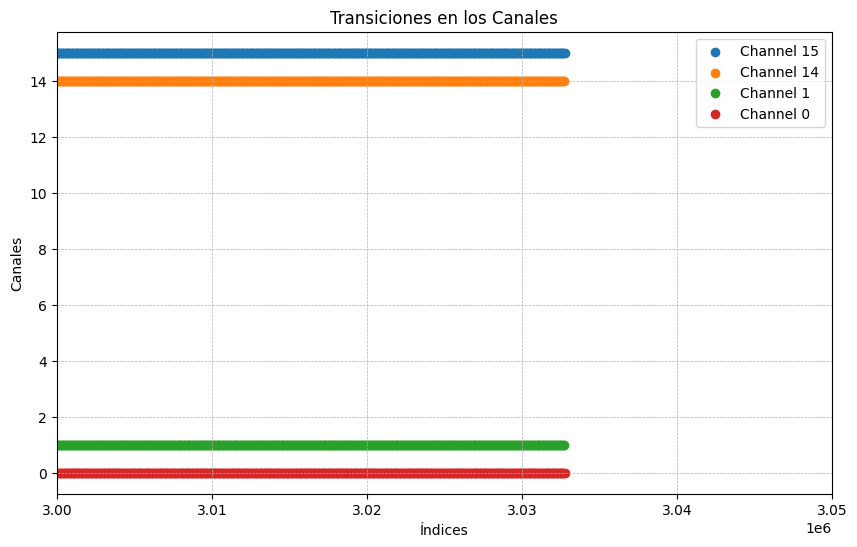

In [156]:
import matplotlib.pyplot as plt

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Graficar los puntos de transición
plt.scatter(transitions_15, [15]*len(transitions_15), label='Channel 15')
plt.scatter(transitions_14, [14]*len(transitions_14), label='Channel 14')
plt.scatter(transitions_1, [1]*len(transitions_1), label='Channel 1')
plt.scatter(transitions_0, [0]*len(transitions_0), label='Channel 0')

# Configuración de la escala logarítmica en el eje x
plt.xscale('linear')
#plt.xlim(3000000, 3050000)
plt.yscale('linear')

# Etiquetas y leyenda
plt.xlabel('Índices')
plt.ylabel('Canales')
plt.title('Transiciones en los Canales')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mostrar la gráfica
plt.show()

In [100]:
print(sum(channel_0))
print(sum(channel_1))
print(sum(channel_14))
print(sum(channel_15))
print(sum(channel_13))


0
0
0
0
13000000


In [101]:
print("Cuentas canal 0: ", counts_channel_0)
print("Cuentas canal 1: ", counts_channel_1)
print("Cuentas canal 2: ", counts_channel_2)
print("Cuentas canal 3: ", counts_channel_3)
print("Cuentas canal 4: ", counts_channel_4)
print("Cuentas canal 5: ", counts_channel_5)
print("Cuentas canal 6: ", counts_channel_6)
print("Cuentas canal 7: ", counts_channel_7)
print("Cuentas canal 8: ", counts_channel_8)
print("Cuentas canal 9: ", counts_channel_9)
print("Cuentas canal 10: ", counts_channel_10)
print("Cuentas canal 11: ", counts_channel_11)
print("Cuentas canal 12: ", counts_channel_12)
print("Cuentas canal 13: ", counts_channel_13)
print("Cuentas canal 14: ", counts_channel_14)
print("Cuentas canal 15: ", counts_channel_15)

Cuentas canal 0:  0
Cuentas canal 1:  0
Cuentas canal 2:  0
Cuentas canal 3:  0
Cuentas canal 4:  0
Cuentas canal 5:  0
Cuentas canal 6:  0
Cuentas canal 7:  0
Cuentas canal 8:  0
Cuentas canal 9:  0
Cuentas canal 10:  0
Cuentas canal 11:  0
Cuentas canal 12:  0
Cuentas canal 13:  25
Cuentas canal 14:  0
Cuentas canal 15:  0


In [102]:
coincidence_15_0 = channel_15 & channel_0
C_15_0 = sum((coincidence_15_0[1:] == 1) & (coincidence_15_0[:-1] == 0))

coincidence_14_0 = channel_14 & channel_0
C_14_0 = sum((coincidence_14_0[1:] == 1) & (coincidence_14_0[:-1] == 0))

coincidence_15_1 = channel_15 & channel_1
C_15_1 = sum((coincidence_15_1[1:] == 1) & (coincidence_15_1[:-1] == 0))

coincidence_14_1 = channel_14 & channel_1
C_14_1 = sum((coincidence_14_1[1:] == 1) & (coincidence_14_1[:-1] == 0))

In [103]:
print("Coincidences 15_0: ", C_15_0)
print("Coincidences 14-0: ", C_14_0)
print("Coincidences 15-1: ", C_15_1)
print("Coincidences 14-1: ", C_14_1)

Coincidences 15_0:  0
Coincidences 14-0:  0
Coincidences 15-1:  0
Coincidences 14-1:  0
